In [1]:
1

[1] 1

In [2]:
library(qdapRegex) 
library(stringr)    
library(tidyverse)  
library(SnowballC)    
library(wordcloud)  
library(tidytext)
library(RColorBrewer)
library(tm)
library(quanteda)
library(data.table)
library(ggplot2)
library(dplyr)
library(Matrix)
library(stringr)

### process description

In [7]:
data <- read.csv("episodes_with_category_and_showname.csv", stringsAsFactors = FALSE)

In [8]:
# Define the text cleaning function
clean_description <- function(text) {
  # 1. Remove specified phrases
  text <- str_replace_all(
    text,
    "Learn more about your ad choices\\. Visit podcastchoices\\.com/adchoices", 
    ""
  )
  # 2. Remove URLs
  text <- str_replace_all(text, "http[s]?://\\S+", "")  # Remove URLs
  # 3. Remove punctuation
  text <- str_remove_all(text, "[[:punct:]]")
  # 4. Remove numbers
  text <- str_remove_all(text, "\\d+")
  # 5. Convert to lowercase
  text <- tolower(text)
  # 6. Remove extra whitespace
  text <- str_squish(text)  # Remove extra spaces
  return(text)
}

# Apply the cleaning function to the description column
data$description <- clean_description(data$description)

# Remove rows where the description is empty
data <- data[!is.na(data$description) & data$description != "", ]

In [9]:
# Save the cleaned data to a new CSV file
write.csv(data, "cleaned_descriptions.csv", row.names = FALSE)

### token

In [13]:
data <- read.csv("cleaned_descriptions.csv", stringsAsFactors = FALSE)

In [14]:
# Check for missing values in the dataset
missing_summary <- colSums(is.na(data))
print("Summary of Missing Values:")
print(missing_summary)

# Count the number of rows with missing values
missing_rows <- sum(rowSums(is.na(data)) > 0)
cat("Number of rows with missing values:", missing_rows, "\n")

# Remove rows with missing values
data_cleaned <- data %>%
  drop_na()  # Drop all rows with missing values

# Print the new dimensions of the cleaned data
cat("New dimensions of the data after removing missing rows:", dim(data_cleaned), "\n")

[1] "Summary of Missing Values:"
          show_id              name       description      release_date 
                0                 0                 0                 0 
 duration_minutes                id audio_preview_url          explicit 
                0                 0                 0                 0 
         language          category         show_name 
                0                 0                 0 
Number of rows with missing values: 0 
New dimensions of the data after removing missing rows: 407397 11 


In [15]:
# podcast stop words
custom_stop_words <- tibble(word = c(
  "spotify", "podcast", "podcasts", "listen", "episode", "show", 
  "omnystudiocomlistener", "megaphonefmadchoices", "acastcomprivacy", 
  "hosted", "ad", "free", "learn", "choices", "join", "privacy", "follow",
  "de", "la", "en", "el", "hour", "day","visit","episodes","information","support"
))

custom_stop_words <- tibble(word = c(
  "spotify", "podcast", "podcasts", "listen", "episode", "episodes", "show", 
  "omnystudiocomlistener", "megaphonefmadchoices", "acastcomprivacy", 
  "hosted", "ad", "free", "learn", "choices", "join", "privacy", 
  "de", "la", "en", "el", "hour", "day", "visit",
  "subscribe", "follow", "support", "click", "share", 
  "website", "www", "https", "http", "com", "dot", 
  "content", "info", "details"
))

In [16]:
token_desc <- data %>%
  select(description, show_name, name, category) %>% 
  unnest_tokens(word, description)     %>% 
  anti_join(stop_words, by = "word") %>%            # Remove standard stop words
  anti_join(custom_stop_words, by = "word")  

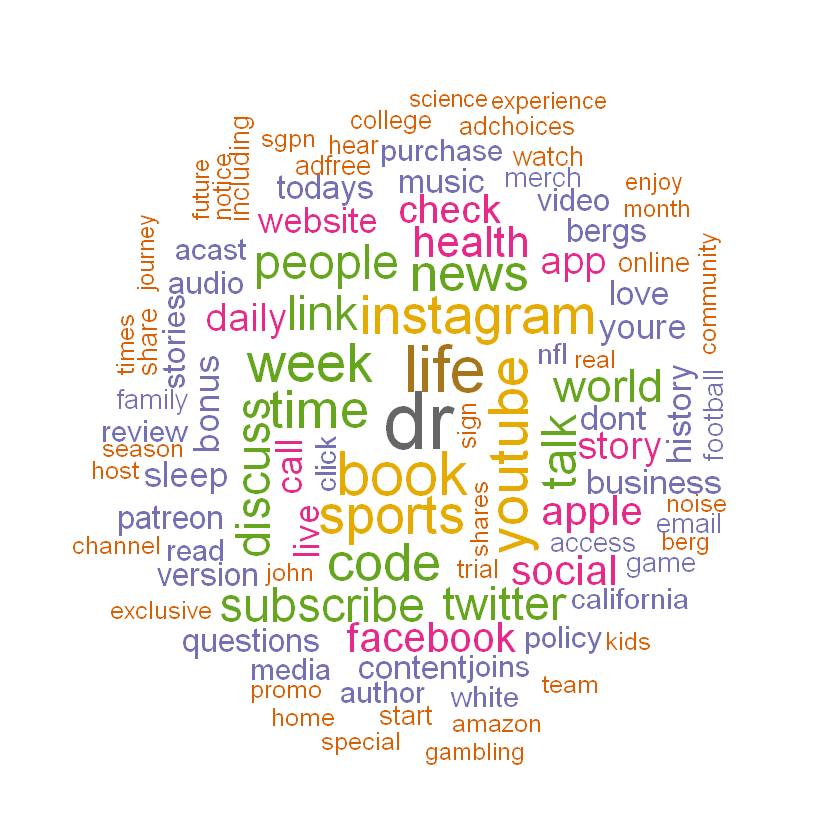

In [13]:
draw_global_wordcloud <- function(data) {
  word_freq <- data %>%
    count(word, sort = TRUE)  
  
  # 绘制全局词云
  wordcloud(
    words = word_freq$word, 
    freq = word_freq$n, 
    min.freq = 5,                           # 设置最低显示频率
    max.words = 100,                        # 限制最多显示 100 个单词
    scale = c(4, 0.5),                      # 调整字体大小范围（最大4倍，最小0.5倍）
    colors = brewer.pal(8, "Dark2"),         # 使用更加柔和的调色板
    random.order = FALSE,                   # 高频词固定在中心
    rot.per = 0.2                           # 20% 的单词旋转
  )
}

draw_global_wordcloud(token_desc)

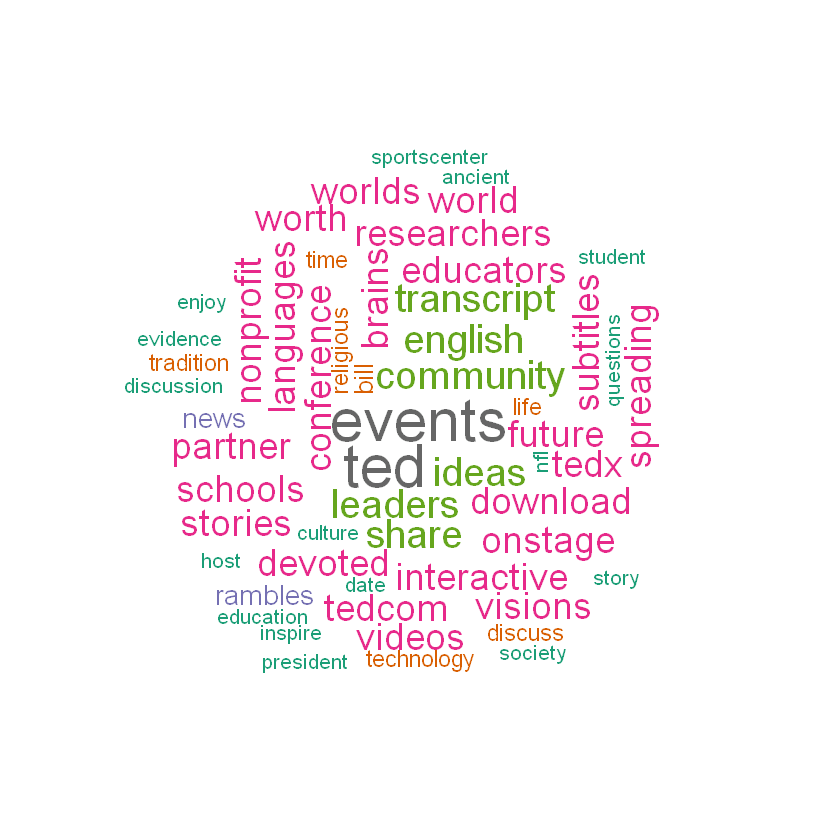

In [14]:
draw_show_wordcloud <- function(data, name) {
  word_freq <- data %>%
    filter(show_name == name) %>%        # 筛选指定节目的单词
    count(word, sort = TRUE)                  # 统计单词频率
  
  wordcloud(
    words = word_freq$word, 
    freq = word_freq$n, 
    min.freq = 2,                             # 设置最低频率
    max.words = 100,                          # 限制最多显示 100 个单词
    scale = c(3, 0.8),                        # 调整字体大小范围
    colors = brewer.pal(8, "Dark2"),          # 深色调调色板
    random.order = FALSE,                     # 高频词固定在中心
    rot.per = 0.1                             # 10% 的单词旋转
  )
}

draw_show_wordcloud(token_desc, "Lex Fridman Podcast")

In [15]:
# Tokenize descriptions and calculate word frequencies by category
tokens_by_category <- data %>%
  unnest_tokens(word, description) %>%              # Tokenize text into words
  anti_join(stop_words, by = "word") %>%            # Remove standard stop words
  anti_join(custom_stop_words, by = "word") %>%     # Remove custom stop words
  count(category, word, sort = TRUE)                # Count word frequencies by category

# Get top 10 words for each category
top_words_by_category <- tokens_by_category %>%
  group_by(category) %>%
  slice_max(n, n = 10) %>%                          # Get top 10 words for each category
  ungroup()

In [16]:
# Remove the first row for each category
top_words_by_category_modified <- top_words_by_category %>%
  group_by(category) %>%
  slice(-1) %>%  # Remove the first row for each category
  ungroup()

# Split into groups of 10 and create two new columns: "Words" and "Counts"
top_words_grouped <- top_words_by_category_modified %>%
  group_by(category) %>%
  mutate(group = ceiling(row_number() / 10)) %>%  # Assign group numbers (10 words per group)
  group_by(category, group) %>%
  summarize(
    Words = paste(word, collapse = ", "),    # Combine words into a single column
    Counts = paste(n, collapse = ", ")       # Combine counts into a single column
  ) %>%
  ungroup() %>%
  select(-group)  # Remove group column if not needed

# Save the result to a CSV file
write.csv(top_words_grouped, "top_words_grouped.csv", row.names = FALSE)

# View the modified table
print(top_words_grouped)

`summarise()` has grouped output by 'category'. You can override using the `.groups` argument.


# A tibble: 20 × 3
   category                Words                                          Counts
   <chr>                   <chr>                                          <chr> 
 1 Arts                    code, acast, glenn, story, policy, discuss, w… 6532,…
 2 Business                bloomberg, carol, news, massar, people, ceo, … 9009,…
 3 Comedy                  dad, jokes, comedy, funny, joke, subscribe, f… 11622…
 4 Culture                 acast, subscribe, content, culture, todays, w… 7634,…
 5 Education               time, teacher, people, wire, discuss, talk, s… 3334,…
 6 Fiction                 stories, tale, audiobooks, tv, tall, short, w… 5500,…
 7 Health                  bergs, health, berg, keto, life, clients, pm,… 31706…
 8 History                 war, world, story, people, author, hit, life,… 4886,…
 9 Lifestyle               white, sleep, sounds, sound, relaxing, life, … 16599…
10 Music                   music, cove, premium, con, bedtime, bonus, co… 4808,…
11 News  

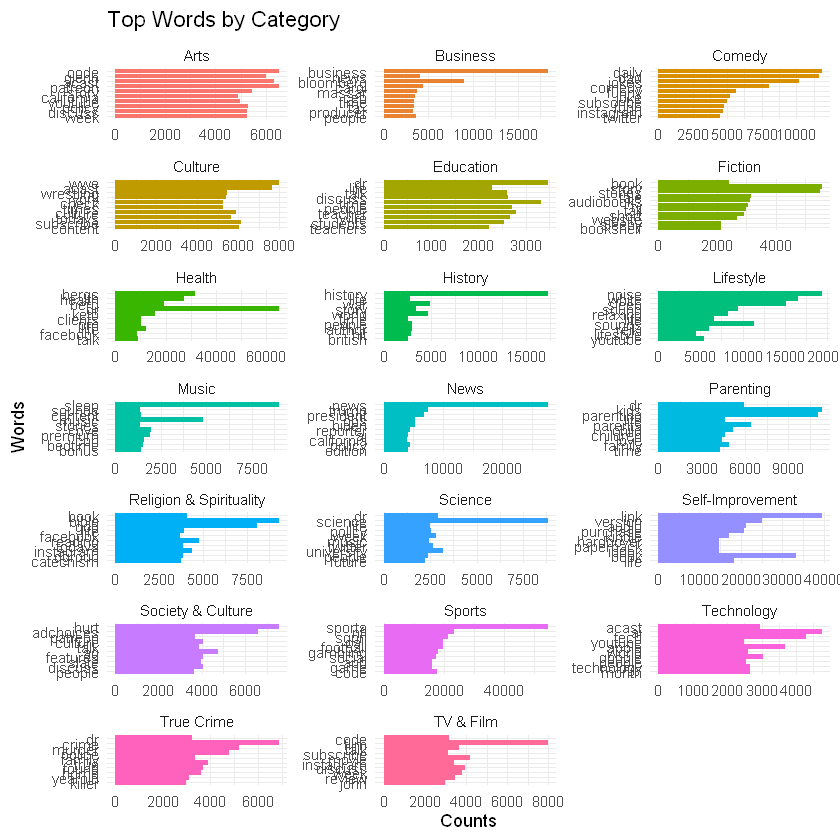

In [17]:
# Bar Plot for Each Category
ggplot(top_words_by_category, aes(x = reorder(word, n), y = n, fill = category)) +
  geom_col(show.legend = FALSE) +
  facet_wrap(~ category, scales = "free", ncol = 3) +         # Create one plot for each category
  coord_flip() +                                    # Flip coordinates for easier reading
  labs(
    title = "Top Words by Category",
    x = "Words",
    y = "Counts"
  ) +
  theme_minimal()

In [18]:
# Save the bar plot as a PNG image
ggsave("top_words_by_category.png", 
       plot = last_plot(),     # Automatically saves the last plot generated
       width = 10,            # Width of the image in inches
       height = 8,            # Height of the image in inches
       dpi = 300)             # Resolution in dots per inch (300 is print quality)

# Print a message to confirm the image was saved
cat("Bar plot saved as 'top_words_by_category.png'\n")

Bar plot saved as 'top_words_by_category.png'


In [19]:
# Filter the tokens for the word "ai" in the "Technology" category
ai_count <- tokens_by_category %>%
  filter(category == "Technology" & word == "ai") %>%
  summarize(total_count = sum(n))

# Print the result
cat("The word 'ai' appears", ai_count$total_count, "times in the 'Technology' category.\n")

The word 'ai' appears 4752 times in the 'Technology' category.


In [111]:
help(bind_tf_idf)

### pca

In [ ]:
words_episode = token_desc %>% count(word,show_name,sort=TRUE)

dtm_description = words_episode %>% cast_sparse(show_name,word,n)
dtm_description_mat = as.matrix(dtm_description)
pca_outr = prcomp(dtm_description_mat)

In [28]:
head(token_desc)

,show_name,name,category,word
,<chr>,<chr>,<chr>,<chr>
1,Science Vs,How a Nuclear Lab Helped Catch a Serial Killer,Science,medical
2,Science Vs,How a Nuclear Lab Helped Catch a Serial Killer,Science,center
3,Science Vs,How a Nuclear Lab Helped Catch a Serial Killer,Science,california
4,Science Vs,How a Nuclear Lab Helped Catch a Serial Killer,Science,patients
5,Science Vs,How a Nuclear Lab Helped Catch a Serial Killer,Science,dying
6,Science Vs,How a Nuclear Lab Helped Catch a Serial Killer,Science,doesnt


In [25]:
# 保存前 10 个主成分
pca_scores <- as.data.frame(pca_outr$x[, 1:10])  # 选择前 10 个主成分
pca_scores$show_name <- rownames(pca_outr$x)    # 添加节目名称

# 保存为 CSV 文件
write.csv(pca_scores, "pca_scores2.csv", row.names = FALSE)

In [41]:
# 保存 PCA 的公式（加载矩阵）
pca_formula <- as.data.frame(pca_outr$rotation)  # 提取加载矩阵
pca_formula$variable <- rownames(pca_outr$rotation)  # 添加变量名称

# 保存加载矩阵为 CSV 文件
#write.csv(pca_formula, "pca_formula.csv", row.names = FALSE)

# 使用 fwrite 保存
fwrite(pca_formula, "pca_formula.csv")

In [29]:
# 假设 pca_out 是通过 prcomp 得到的 PCA 模型
summary(pca_outr)  # 查看每个主成分的解释方差比例

# 查看主成分加载矩阵（即原始变量在线性组合中的权重）
pca_outr$rotation  # 每个变量在主成分上的权重（矩阵）

# 查看主成分得分（即数据在主成分空间中的坐标）
pca_outr$x  # 投影后的数据矩阵，每行对应一个数据点

# 查看每个主成分的标准偏差和方差解释比例
pca_outr$sdev  # 每个主成分的标准偏差
explained_variance <- pca_outr$sdev^2 / sum(pca_outr$sdev^2)  # 方差解释比例
print(explained_variance)

Importance of components:
                            PC1       PC2       PC3       PC4       PC5
Standard deviation     2769.419 2556.6526 1.518e+03 1.051e+03 976.61812
Proportion of Variance    0.268    0.2284 8.053e-02 3.859e-02   0.03333
Cumulative Proportion     0.268    0.4965 5.770e-01 6.156e-01   0.64891
                             PC6       PC7       PC8       PC9      PC10
Standard deviation     867.29942 791.36206 751.26627 640.09246 549.45327
Proportion of Variance   0.02629   0.02189   0.01972   0.01432   0.01055
Cumulative Proportion    0.67520   0.69708   0.71681   0.73113   0.74168
                            PC11      PC12      PC13      PC14      PC15
Standard deviation     531.77900 523.50435 500.23451 454.51169 445.38326
Proportion of Variance   0.00988   0.00958   0.00874   0.00722   0.00693
Cumulative Proportion    0.75156   0.76114   0.76988   0.77710   0.78403
                           PC16      PC17      PC18      PC19      PC20
Standard deviation     437.757

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,⋯,PC791,PC792,PC793,PC794,PC795,PC796,PC797,PC798,PC799,PC800
dr,-0.6577413667,5.116419e-02,0.039758580,-0.0115818339,-0.005261162,-0.002761063,-0.0037577276,0.019030952,-0.038982819,0.004657696,⋯,0.0036609555,0.0003123562,-0.0060273099,-9.164409e-03,-6.070829e-03,-0.0013311152,0.0014838410,1.448467e-03,0.0013298778,0.07944853
link,-0.0313413401,-4.442594e-01,0.019718592,-0.0111646761,-0.003894702,-0.008047641,-0.0008822738,0.015837271,-0.047005482,0.037491607,⋯,-0.0057715703,-0.0089624315,0.0005569203,-1.255933e-03,1.363002e-03,0.0045123305,-0.0051899633,-3.816870e-04,-0.0000107588,-0.11796590
bergs,-0.4012719714,3.335720e-02,0.029370583,-0.0215469537,-0.019002950,-0.050880339,0.0107816601,-0.075832700,0.026431585,-0.004750161,⋯,-0.0027479586,-0.0053667248,-0.0261106846,-2.989138e-02,-3.662979e-03,-0.0127760351,-0.0049011190,-2.184205e-04,-0.0011557337,-0.08314321
book,-0.0297426660,-4.077759e-01,0.011795067,0.0004468387,0.014575723,0.017105103,0.0159857657,0.038335734,0.006015201,-0.013660834,⋯,-0.0043323509,0.0069511966,-0.0008184486,5.931105e-03,-9.650031e-03,-0.0079965056,0.0014911060,-1.149475e-03,-0.0021799752,-0.10620889
version,-0.0226511377,-3.371888e-01,0.015937781,0.0182590590,-0.013628894,-0.027169415,-0.0014583211,-0.042404954,0.013678606,-0.008747127,⋯,-0.0005580384,-0.0092635294,-0.0051813110,-4.365769e-05,-2.010401e-03,0.0019206715,0.0029951499,1.595967e-03,0.0023536391,0.35359387
audio,-0.0192014368,-2.823513e-01,0.013729823,-0.0084294905,-0.003628402,-0.021643520,0.0131884733,-0.021349984,0.010578080,-0.010990149,⋯,0.0012838649,0.0035468456,0.0102254944,3.021215e-05,-3.099216e-03,-0.0011625999,0.0050536716,-1.392108e-04,-0.0002244834,0.10807374
purchase,-0.0187297748,-2.812969e-01,0.008484276,-0.0112791450,-0.009160565,-0.023514786,0.0066565229,-0.018040217,0.011331698,-0.005273120,⋯,0.0086220495,-0.0011710681,0.0026928979,-3.902079e-04,-2.112949e-03,-0.0006801974,0.0022770989,3.516849e-05,-0.0002782860,-0.07187875
berg,-0.2465796903,2.049605e-02,0.017949743,-0.0132381032,-0.011679381,-0.031207285,0.0066251326,-0.046458246,0.016496738,-0.003029033,⋯,-0.0026872441,-0.0025569567,-0.0157806047,-1.894594e-02,-2.323789e-03,-0.0077378727,-0.0035390932,-4.203444e-06,-0.0007168644,0.09935670
kindle,-0.0151748134,-2.345250e-01,0.012633529,-0.0103575189,-0.007617157,-0.025063167,0.0066705650,-0.023187938,0.007676479,-0.004165405,⋯,0.0040655357,-0.0014792764,-0.0016590747,-1.081551e-03,-1.183113e-03,-0.0001697630,0.0013490731,-5.931291e-04,0.0002055061,-0.23327440
sports,-0.0052400229,-3.235726e-03,-0.334486170,0.0178625279,0.467410139,-0.304858611,-0.0730195989,-0.061413206,-0.060903942,0.012262196,⋯,-0.0073814895,0.0020762476,-0.0010915714,-7.786594e-03,1.265425e-03,0.0029947440,0.0052895747,-4.721763e-04,-0.0004567061,0.01019614


,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,⋯,PC791,PC792,PC793,PC794,PC795,PC796,PC797,PC798,PC799,PC800
Dr. Berg’s Healthy Keto and Intermittent Fasting Podcast,-7.755708e+04,5494.626008,1705.604565,-599.56906,-456.74306,-964.4781,170.15367,-1078.57247,272.90455,-3.613114e+01,⋯,-2.434308e-07,-3.439231e-07,-1.341946e-06,-1.410186e-06,-1.614084e-07,-5.080656e-07,-1.641031e-07,-6.228649e-09,-3.466389e-08,6.171503e-08
Coach Corey Wayne,-5.437693e+03,-71788.607927,1370.553089,-542.31933,-346.85462,-901.0877,198.58837,-637.61987,157.13330,-5.838240e+01,⋯,4.890504e-07,-8.813395e-08,-1.346484e-07,-1.036658e-07,-7.769088e-08,-1.278431e-08,7.701031e-08,-1.906125e-08,1.926281e-08,4.676699e-08
Hurrdat Sports Radio,-2.992433e+02,-30.562053,-8349.515682,1502.96909,19666.22442,-13160.0829,-8395.92424,945.07514,-1549.16564,-1.391353e+02,⋯,2.113993e-06,8.675135e-07,6.777310e-07,-8.978094e-07,7.069597e-08,1.682250e-07,5.274147e-07,1.353721e-09,6.224399e-08,4.731039e-08
Relaxing White Noise,-3.741800e+02,-394.781260,-1494.337943,27358.09207,-5194.54233,-4326.3155,593.61421,-1415.51237,125.65354,1.725635e+01,⋯,-7.237405e-07,-1.670678e-06,1.544303e-07,-3.040077e-07,-1.767879e-07,3.131096e-07,1.620127e-08,2.923294e-09,2.502954e-08,8.121960e-08
The Early Edge: A Daily Sports Betting Podcast,-6.422108e+02,-466.642227,-9284.619161,2520.72774,12798.92211,5079.9552,16270.39961,-6370.44984,-3121.39469,-1.354000e+03,⋯,-2.094576e-06,1.041250e-07,2.376669e-07,-1.406472e-06,1.509553e-06,-9.015928e-07,-1.855005e-07,1.032907e-09,5.239526e-08,3.840421e-07
Sports Gambling Podcast,-1.569141e+03,-972.983849,-30415.105757,-2759.19411,-7464.27798,-1468.1128,-640.02294,-66.12652,-211.59724,-8.853852e-01,⋯,-5.047212e-06,2.864604e-06,5.780691e-07,5.126538e-07,-9.561933e-08,-1.746359e-06,1.299423e-06,-1.043618e-07,-2.240356e-07,3.936386e-08
Daily Dad Jokes,-4.371670e+02,-895.023741,-3349.699430,3021.15685,4255.75503,14321.2022,-11946.52605,-11452.73600,119.14203,9.040386e+02,⋯,-9.314392e-07,1.308820e-06,2.054542e-06,-1.665465e-06,8.251919e-08,-4.457177e-07,3.575009e-07,8.002386e-09,8.017488e-09,3.022438e-08
Sports Gambling Podcast Network,-1.288999e+03,-743.484927,-25174.651204,-2260.54919,-5615.06621,-1433.9810,-1136.28115,-547.76600,-451.54740,-6.623168e+02,⋯,5.131930e-06,-2.302799e-06,-1.166203e-07,7.179603e-07,6.159958e-08,2.019281e-06,-1.579994e-06,1.493627e-07,5.709648e-08,9.431411e-08
Mo News,-1.151830e+02,-172.603649,-599.134741,574.55185,1545.09046,1552.9604,-676.60082,1048.42690,2078.84755,-3.181378e+03,⋯,5.129861e-06,1.195351e-05,3.659572e-06,4.490643e-06,2.655521e-06,3.686161e-07,1.316073e-06,-6.068713e-08,-4.074295e-07,2.496506e-08
Bloomberg Businessweek,-6.044055e+02,-133.488198,-667.191337,543.64615,1307.91019,1418.4777,-575.26230,2365.16372,3773.17872,-3.603909e+03,⋯,2.211989e-06,2.347029e-06,3.133500e-06,-3.178152e-06,1.055317e-06,1.612097e-06,4.459998e-07,-1.351495e-07,-1.440561e-08,2.156387e-08


[1] 2.769419e+03 2.556653e+03 1.518031e+03 1.050810e+03 9.766181e+02
  [6] 8.672994e+02 7.913621e+02 7.512663e+02 6.400925e+02 5.494533e+02
 [11] 5.317790e+02 5.235043e+02 5.002345e+02 4.545117e+02 4.453833e+02
 [16] 4.377578e+02 4.362745e+02 4.236316e+02 4.115453e+02 4.077723e+02
 [21] 3.961464e+02 3.889879e+02 3.813539e+02 3.745677e+02 3.678105e+02
 [26] 3.640543e+02 3.520996e+02 3.483546e+02 3.388666e+02 3.371268e+02
 [31] 3.347643e+02 3.309810e+02 3.159763e+02 2.994127e+02 2.965553e+02
 [36] 2.903525e+02 2.817886e+02 2.737991e+02 2.719689e+02 2.692443e+02
 [41] 2.630018e+02 2.584225e+02 2.557577e+02 2.515185e+02 2.442039e+02
 [46] 2.385005e+02 2.365130e+02 2.310153e+02 2.275783e+02 2.252269e+02
 [51] 2.225456e+02 2.171873e+02 2.149068e+02 2.098889e+02 2.044644e+02
 [56] 1.996781e+02 1.994240e+02 1.948256e+02 1.916011e+02 1.892005e+02
 [61] 1.870254e+02 1.830430e+02 1.806770e+02 1.786547e+02 1.769499e+02
 [66] 1.739036e+02 1.724721e+02 1.707122e+02 1.673849e+02 1.634083e+02
 [71] 1.627528e+02 1.598141e+02 1.593696e+02 1.586464e+02 1.561311e+02
 [76] 1.552341e+02 1.546158e+02 1.533649e+02 1.515148e+02 1.508383e+02
 [81] 1.490745e+02 1.468770e+02 1.456237e+02 1.447075e+02 1.435289e+02
 [86] 1.405750e+02 1.391789e+02 1.386649e+02 1.377828e+02 1.367219e+02
 [91] 1.354582e+02 1.337735e+02 1.335538e+02 1.302299e+02 1.297060e+02
 [96] 1.282116e+02 1.261785e+02 1.257524e+02 1.237418e+02 1.231023e+02
[101] 1.223484e+02 1.206950e+02 1.196528e+02 1.191074e+02 1.184309e+02
[106] 1.180247e+02 1.164046e+02 1.146427e+02 1.141315e+02 1.136773e+02
[111] 1.131828e+02 1.119576e+02 1.105790e+02 1.104161e+02 1.093707e+02
[116] 1.091403e+02 1.076676e+02 1.074834e+02 1.069067e+02 1.058476e+02
[121] 1.055686e+02 1.043194e+02 1.026426e+02 1.019643e+02 1.007892e+02
[126] 1.003269e+02 9.947512e+01 9.885006e+01 9.774133e+01 9.719501e+01
[131] 9.654015e+01 9.606106e+01 9.474124e+01 9.454899e+01 9.424251e+01
[136] 9.311271e+01 9.212964e+01 9.159168e+01 9.096810e+01 9.077189e+01
[141] 8.962816e+01 8.949594e+01 8.845742e+01 8.820737e+01 8.774455e+01
[146] 8.715904e+01 8.644867e+01 8.605140e+01 8.559732e+01 8.475864e+01
[151] 8.458026e+01 8.391486e+01 8.335738e+01 8.310474e+01 8.256395e+01
[156] 8.203920e+01 8.157871e+01 8.120926e+01 8.090242e+01 7.998064e+01
[161] 7.947746e+01 7.913487e+01 7.825325e+01 7.798136e+01 7.714228e+01
[166] 7.687822e+01 7.628520e+01 7.592440e+01 7.590782e+01 7.459826e+01
[171] 7.411211e+01 7.360334e+01 7.348432e+01 7.192386e+01 7.159611e+01
[176] 7.125290e+01 7.077461e+01 7.048853e+01 6.988034e+01 6.944334e+01
[181] 6.927772e+01 6.848623e+01 6.808833e+01 6.742813e+01 6.727875e+01
[186] 6.705436e+01 6.658651e+01 6.639673e+01 6.569911e+01 6.507397e+01
[191] 6.459420e+01 6.422813e+01 6.416999e+01 6.375877e+01 6.301145e+01
[196] 6.292346e+01 6.257938e+01 6.251070e+01 6.217708e+01 6.168725e+01
[201] 6.135764e+01 6.095909e+01 6.084692e+01 6.029875e+01 5.986624e+01
[206] 5.935346e+01 5.926390e+01 5.876466e+01 5.844066e+01 5.813141e+01
[211] 5.791931e+01 5.736043e+01 5.659246e+01 5.617656e+01 5.591746e+01
[216] 5.575361e+01 5.542112e+01 5.533405e+01 5.488939e+01 5.459961e+01
[221] 5.390703e+01 5.369288e+01 5.357438e+01 5.319861e+01 5.297094e+01
[226] 5.284615e+01 5.229603e+01 5.199604e+01 5.188133e+01 5.134674e+01
[231] 5.103214e+01 5.099158e+01 5.073802e+01 5.066361e+01 5.024748e+01
[236] 4.975546e+01 4.930067e+01 4.893994e+01 4.876900e+01 4.847593e+01
[241] 4.812024e+01 4.798860e+01 4.790642e+01 4.779651e+01 4.720653e+01
[246] 4.691443e+01 4.678879e+01 4.651798e+01 4.619405e+01 4.602671e+01
[251] 4.586199e+01 4.573137e+01 4.540957e+01 4.491393e+01 4.482617e+01
[256] 4.446308e+01 4.407303e+01 4.395881e+01 4.379188e+01 4.376176e+01
[261] 4.358103e+01 4.307624e+01 4.296309e+01 4.287156e+01 4.252011e+01
[266] 4.232827e+01 4.220978e+01 4.197980e+01 4.190229e+01 4.161818e+01
[271] 4.138862e+01 4.100299e+01 4.080282e+01 4.065615e+01 4.064298e+01
[276] 4.048003e+01 4.014950e+01 3.996433e+01 3.984432e+01 3.964714e+01
[281] 3.952810e+01 3.90585

  [1] 2.680306e-01 2.284286e-01 8.053201e-02 3.858832e-02 3.333164e-02
  [6] 2.628725e-02 2.188555e-02 1.972399e-02 1.431834e-02 1.055039e-02
 [11] 9.882560e-03 9.577401e-03 8.744891e-03 7.219335e-03 6.932261e-03
 [16] 6.696916e-03 6.651609e-03 6.271679e-03 5.918919e-03 5.810889e-03
 [21] 5.484266e-03 5.287851e-03 5.082337e-03 4.903065e-03 4.727760e-03
 [26] 4.631690e-03 4.332496e-03 4.240824e-03 4.012959e-03 3.971857e-03
 [31] 3.916384e-03 3.828365e-03 3.489121e-03 3.132907e-03 3.073396e-03
 [36] 2.946172e-03 2.774943e-03 2.619819e-03 2.584911e-03 2.533379e-03
 [41] 2.417266e-03 2.333821e-03 2.285938e-03 2.210788e-03 2.084070e-03
 [46] 1.987859e-03 1.954867e-03 1.865043e-03 1.809960e-03 1.772751e-03
 [51] 1.730793e-03 1.648451e-03 1.614014e-03 1.539522e-03 1.460974e-03
 [56] 1.393375e-03 1.389831e-03 1.326476e-03 1.282930e-03 1.250983e-03
 [61] 1.222385e-03 1.170883e-03 1.140809e-03 1.115414e-03 1.094228e-03
 [66] 1.056876e-03 1.039549e-03 1.018442e-03 9.791286e-04 9.331585e-04
 [71] 

In [ ]:
# 假设你有一个包含所有 episode 描述的 token 数据
episode_tf_idf <- token_desc %>%
  count(word, name) %>%  # 针对 episode 的单词统计
  bind_tf_idf(word, name, n) %>%
  cast_sparse(name, word, tf_idf)  # 转换为稀疏矩阵

In [120]:
dim(pca_outr$x)

[1] 800 800

In [125]:
dim(episode_tf_idf)  # 查看矩阵的行列数
dim(pca_outr$rotation)

# 计算每个单词的总出现次数
word_freq <- colSums(episode_tf_idf)

# 按频率降序排列并保留前 10,000 个单词
top_words <- sort(word_freq, decreasing = TRUE)[1:10000]

# 筛选出这些高频单词
filtered_tf_idf <- episode_tf_idf[, names(top_words)]
num_components <- 10  # 设置保留的主成分数量
filtered_rotation <- pca_outr$rotation[names(top_words), 1:num_components]  # 只保留前 10 个主成分

dim(filtered_tf_idf)
dim(filtered_rotation)

[1] 358070 475569

[1] 475569    800

[1] 358070  10000

[1] 10000    10

In [126]:
# 保持 filtered_tf_idf 和 filtered_rotation 为稀疏矩阵
filtered_tf_idf_sparse <- as(filtered_tf_idf, "sparseMatrix")
filtered_rotation_sparse <- as(filtered_rotation, "sparseMatrix")

# 矩阵乘法直接使用 %*%
episode_pca_scores <- filtered_tf_idf_sparse %*% filtered_rotation_sparse

# 转化为数据框（仅结果），并添加 episode 名称
episode_pca_scores <- as.data.frame(as.matrix(episode_pca_scores))
episode_pca_scores$name <- rownames(filtered_tf_idf)

In [129]:
# 确保 token_desc 中只有唯一的 name 和 show_name 对应关系
token_desc_unique <- token_desc %>%
  select(name, show_name) %>%
  distinct()

# 将 show_name 添加到 episode_pca_scores 中
episode_pca_scores <- episode_pca_scores %>%
  left_join(token_desc_unique, by = c("name" = "name"))  # 通过 name 进行连接

# 检查结果
head(episode_pca_scores)

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,name,show_name
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
1,-0.014213461,-0.001486776,-0.039206703,0.01142298,0.001078914,0.02793339,-0.018381858,0.055123345,-0.011474859,-0.020752743,"Everything You Need to Know About AA Meetings in Scranton, PA",Technology
2,-0.011771249,-0.015670361,-0.007925717,0.02121250,0.019336149,0.04307559,-0.011033472,0.055616606,-0.006591615,-0.006739592,"""The Arcade"" - Supernatural Short Story - by A.A.Ron",TALL TALE TV - Sci-Fi and Fantasy Short Stories
3,-0.011821636,-0.014946529,-0.007794827,0.02082439,0.018963957,0.04223540,-0.010475952,0.054699609,-0.005084075,-0.006791823,"""Urban Demonology"" - Supernatural Short Story - by A.A.Ron",TALL TALE TV - Sci-Fi and Fantasy Short Stories
4,-0.024008304,-0.017560830,-0.028720650,0.01560881,0.007982801,0.02804270,-0.002790443,0.029081431,-0.009484729,-0.011861697,'The Promises' of 12-Step - A New Freedom and a New Happiness Through the Lense of Soul Recovery,Recover Your Soul: A Spiritual Path to a Happy and Healthy Life
5,-0.009637013,-0.009895462,-0.028097037,0.01335370,0.033919874,0.01634822,0.003075467,0.028534872,0.033041730,-0.045766667,"100K Daily Cases Possible, New NAFTA & Baseball is Back- Wednesday, July 1st, 2020",The NewsWorthy
6,-0.009080183,-0.029567506,-0.030409392,0.01582524,0.018074503,0.04558316,-0.017789379,0.007830506,0.005174229,-0.013431439,133: What About The Jello?,Brooke and Connor Make A Podcast


In [128]:
dim(episode_pca_scores)

[1] 358070     11

In [131]:
# 使用 fwrite 保存
fwrite(episode_pca_scores, "episode_pca_scores.csv")

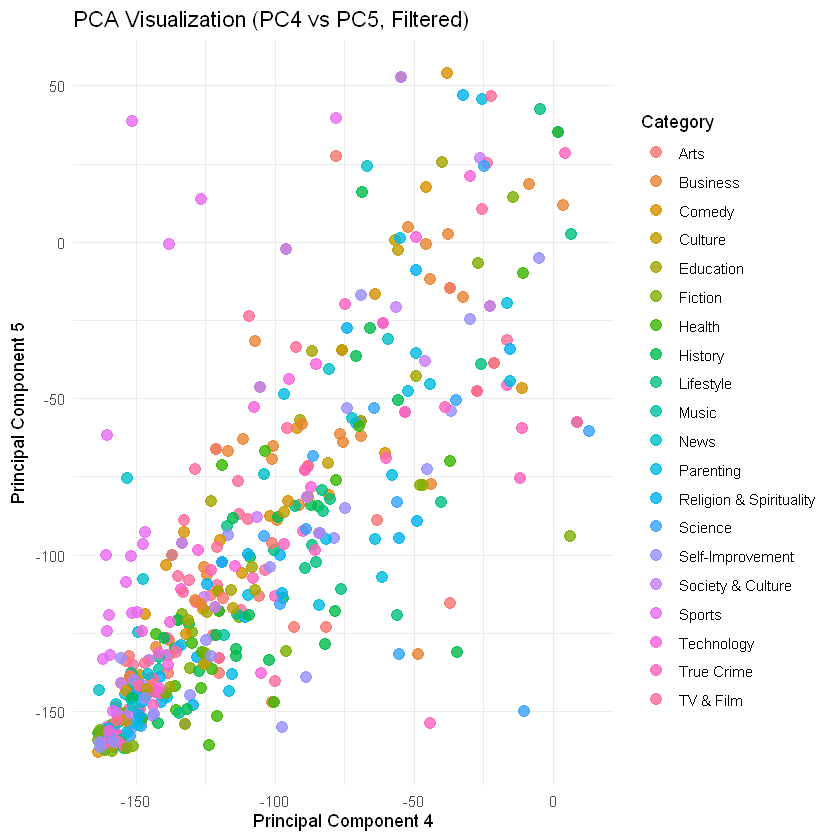

In [68]:
# Function to extract and visualize specified principal components with filtering
plot_pca_components <- function(pca_model, components = c(1, 2), categories, title = "PCA Visualization") {
  # Extract specified components
  pca_scores <- as.data.frame(pca_model$x[, components])
  colnames(pca_scores) <- paste0("PC", components)  # Name the columns (e.g., PC1, PC2)
  pca_scores$show_name <- rownames(pca_model$x)    # Add show names
  
  # Ensure categories are unique and aligned
  categories_df <- token_desc %>%
    select(show_name, category) %>%
    distinct()

  # Merge category data
  pca_scores <- pca_scores %>%
    left_join(categories_df, by = "show_name")
    
  # Calculate quantile-based limits for PC1 and PC2
  pc1_limits <- quantile(pca_scores[[paste0("PC", components[1])]], probs = c(0.2, 0.8), na.rm = TRUE)
  pc2_limits <- quantile(pca_scores[[paste0("PC", components[2])]], probs = c(0.2, 0.8), na.rm = TRUE)

  # Filter data within the quantile range
  filtered_pca_scores <- pca_scores %>%
    filter(
      !!sym(paste0("PC", components[1])) >= pc1_limits[1],
      !!sym(paste0("PC", components[1])) <= pc1_limits[2],
      !!sym(paste0("PC", components[2])) >= pc2_limits[1],
      !!sym(paste0("PC", components[2])) <= pc2_limits[2]
    )

  # Plot the PCA scatter plot
  ggplot(filtered_pca_scores, aes_string(x = paste0("PC", components[1]), y = paste0("PC", components[2]), color = "category")) +
    geom_point(size = 3, alpha = 0.8) +           # Scatter plot
    labs(
      title = title,
      x = paste("Principal Component", components[1]),
      y = paste("Principal Component", components[2]),
      color = "Category"                         # Legend title
    ) +
    theme_minimal() +
    theme(legend.position = "right")
}

# Example usage
plot_pca_components(
  pca_model = pca_outr, 
  components = c(4, 5),  # Specify the components to visualize
  categories = token_desc,  # Provide category data
  title = "PCA Visualization (PC4 vs PC5, Filtered)"
)

In [106]:
# 描述性统计分析 PC4

# 保存前 10 个主成分
pca_scores <- as.data.frame(pca_outr$x[, 1:10])  # 选择前 10 个主成分
pca_scores$show_name <- rownames(pca_outr$x)    # 添加节目名称

# 假设 categories 是一个数据框，包含 show_name 和 category 两列
categories_df <- token_desc %>%
  select(show_name, category) %>%
  distinct()

# 确保类别信息与 PCA 数据对齐
pca_scores <- pca_scores %>%
  left_join(categories_df, by = "show_name")  # 根据 show_name 合并类别信息

# 计算 PC4 均值和标准差
pca_stats <- pca_scores %>%
  group_by(category) %>%
  summarize(
    mean_pc = mean(PC1, na.rm = TRUE),
    sd_pc = sd(PC1, na.rm = TRUE),
    min_pc = min(PC1, na.rm = TRUE),
    max_pc = max(PC1, na.rm = TRUE)
  ) %>%
  arrange(desc(mean_pc))  # 按均值排序

print(pca_stats)

# A tibble: 20 × 5
   category                 mean_pc   sd_pc   min_pc max_pc
   <chr>                      <dbl>   <dbl>    <dbl>  <dbl>
 1 Music                     196.      78.8    -99.5   225.
 2 Fiction                   186.      89.9   -363.    225.
 3 TV & Film                 181.      56.5    -36.0   224.
 4 History                   158.      78.8   -104.    225.
 5 Comedy                    148.     115.    -437.    225.
 6 News                      139.     114.    -199.    225.
 7 True Crime                119.     366.   -2219.    225.
 8 Religion & Spirituality   118.     255.   -1179.    225.
 9 Society & Culture          95.6    235.    -932.    225.
10 Parenting                  63.4    332.   -1572.    225.
11 Business                   56.9    526.   -3328.    225.
12 Culture                    44.9    541.   -3328.    225.
13 Arts                       43.0    509.   -3328.    225.
14 Science                    39.8    348.   -1330.    225.
15 Sports            

Warning message:
"Removed 27 rows containing non-finite outside the scale range (`stat_density()`)."


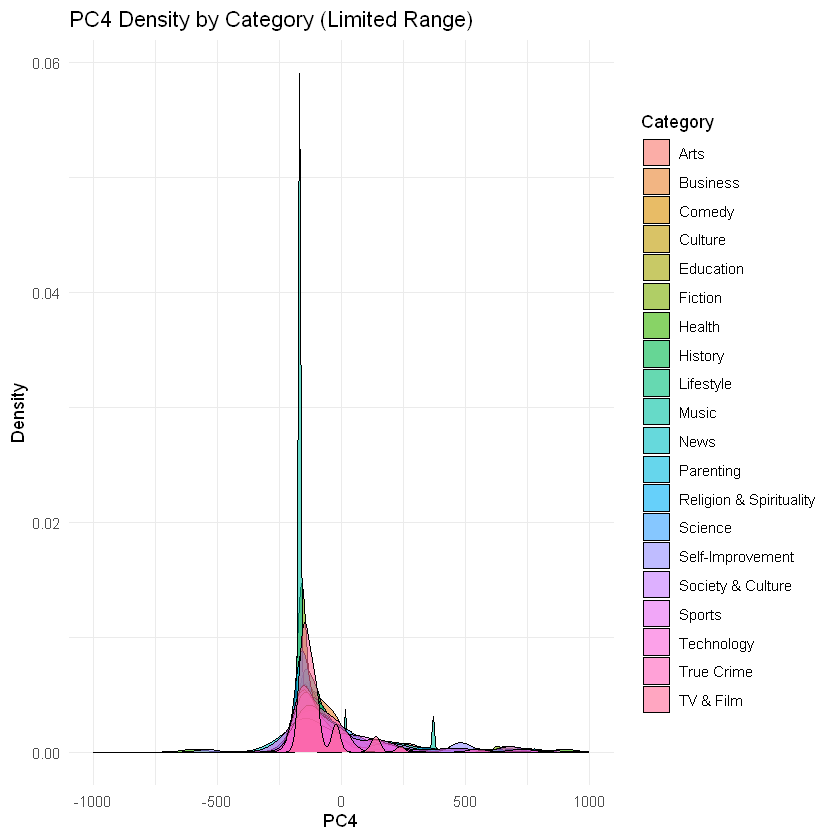

In [91]:
ggplot(pca_scores, aes(x = PC4, fill = category)) +
  geom_density(alpha = 0.6) +
  labs(
    title = "PC4 Density by Category (Limited Range)",
    x = "PC4",
    y = "Density",
    fill = "Category"
  ) +
  xlim(-1000, 1000) +  # 根据数据调整范围
  theme_minimal()

Warning message:
"Removed 818 rows containing non-finite outside the scale range (`stat_density()`)."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message in max(ids, na.rm = TRUE):
"no non-missing arguments to max; returning -Inf"
Warning message in max(ids, na.rm = TRUE):
"no non-missing arguments to max; returning -Inf"
Warning message in max(ids, na.rm = TRUE):
"no non-missing arguments to max; returning -Inf"


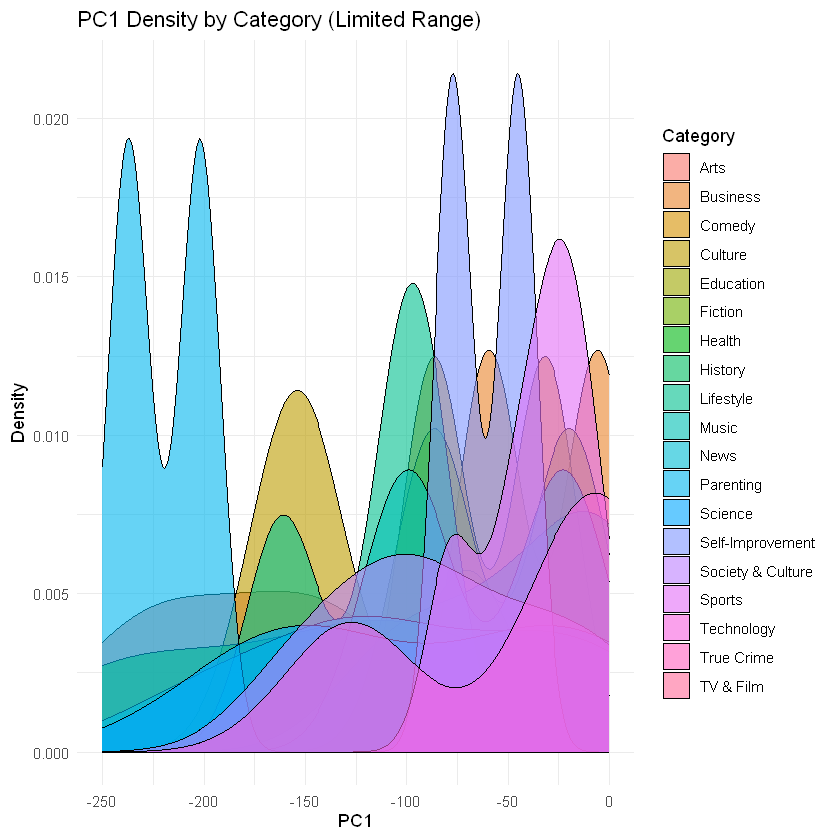

In [105]:
ggplot(pca_scores, aes(x = PC1, fill = category)) +
  geom_density(alpha = 0.6) +
  labs(
    title = "PC1 Density by Category (Limited Range)",
    x = "PC1",
    y = "Density",
    fill = "Category"
  ) +
  xlim(-250, 0) +  # 根据数据调整范围
  theme_minimal()

Warning message:
"Removed 803 rows containing non-finite outside the scale range (`stat_density()`)."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message in max(ids, na.rm = TRUE):
"no non-missing arguments to max; returning -Inf"
Warning message in max(ids, na.rm = TRUE):
"no non-missing arguments to max; returning -Inf"


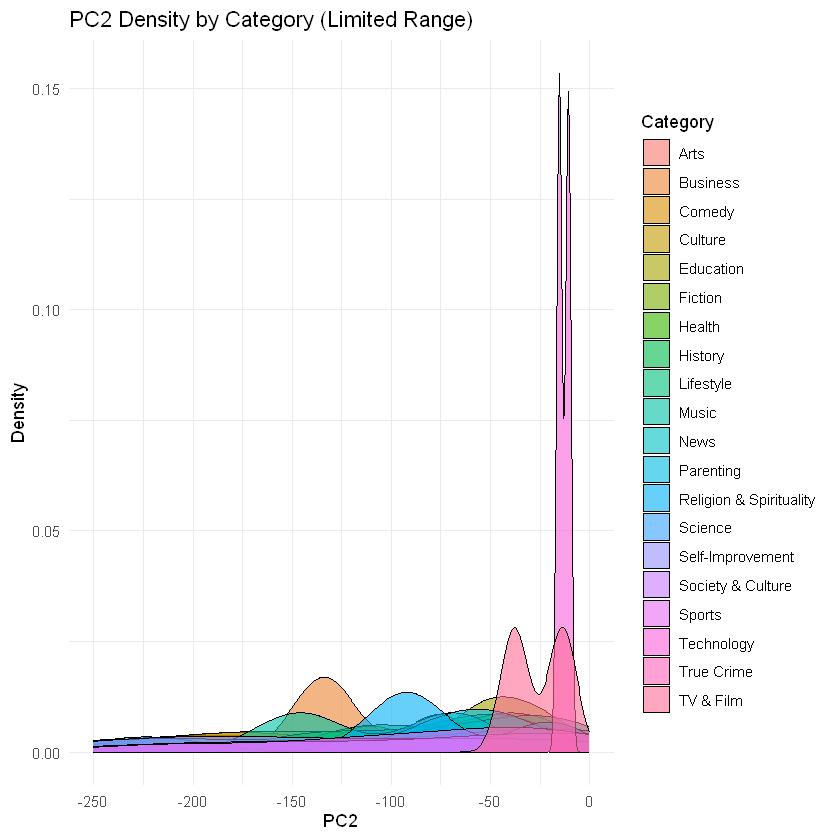

In [104]:
ggplot(pca_scores, aes(x = PC2, fill = category)) +
  geom_density(alpha = 0.6) +
  labs(
    title = "PC2 Density by Category (Limited Range)",
    x = "PC2",
    y = "Density",
    fill = "Category"
  ) +
  xlim(-250, 0) +  # 根据数据调整范围
  theme_minimal()

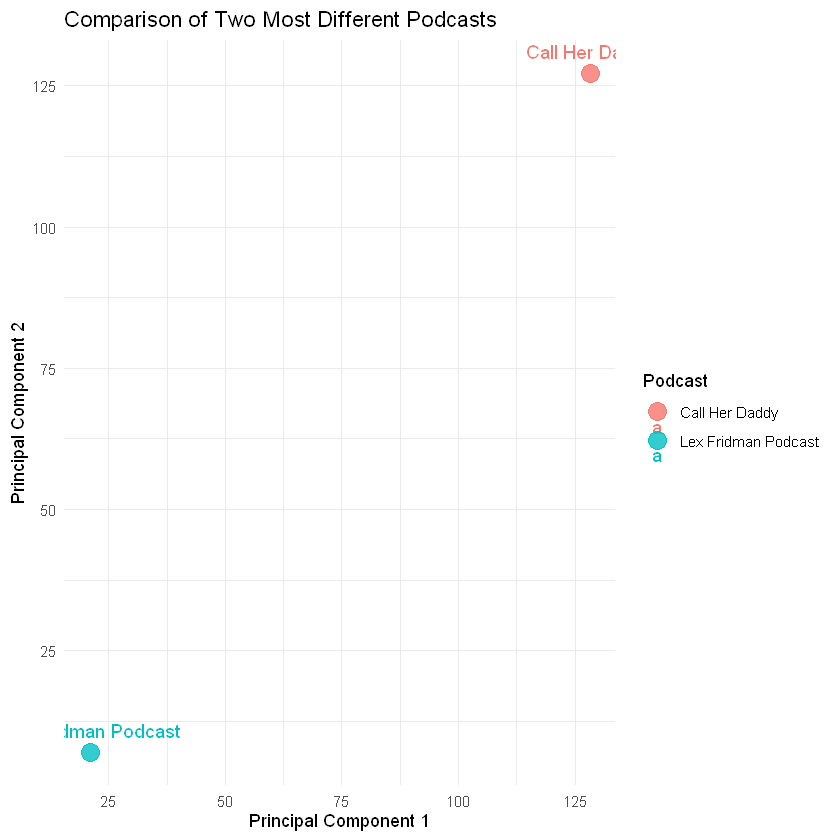

In [107]:
compare_podcasts <- pca_scores %>%
  filter(show_name %in% c("Lex Fridman Podcast", "Call Her Daddy"))

# 绘制对比图
ggplot(compare_podcasts, aes(x = PC1, y = PC2, color = show_name)) +
  geom_point(size = 5, alpha = 0.8) +
  geom_text(aes(label = show_name), vjust = -1, size = 4) +
  labs(
    title = "Comparison of Two Most Different Podcasts",
    x = "Principal Component 1",
    y = "Principal Component 2",
    color = "Podcast"
  ) +
  theme_minimal() +
  theme(legend.position = "right")

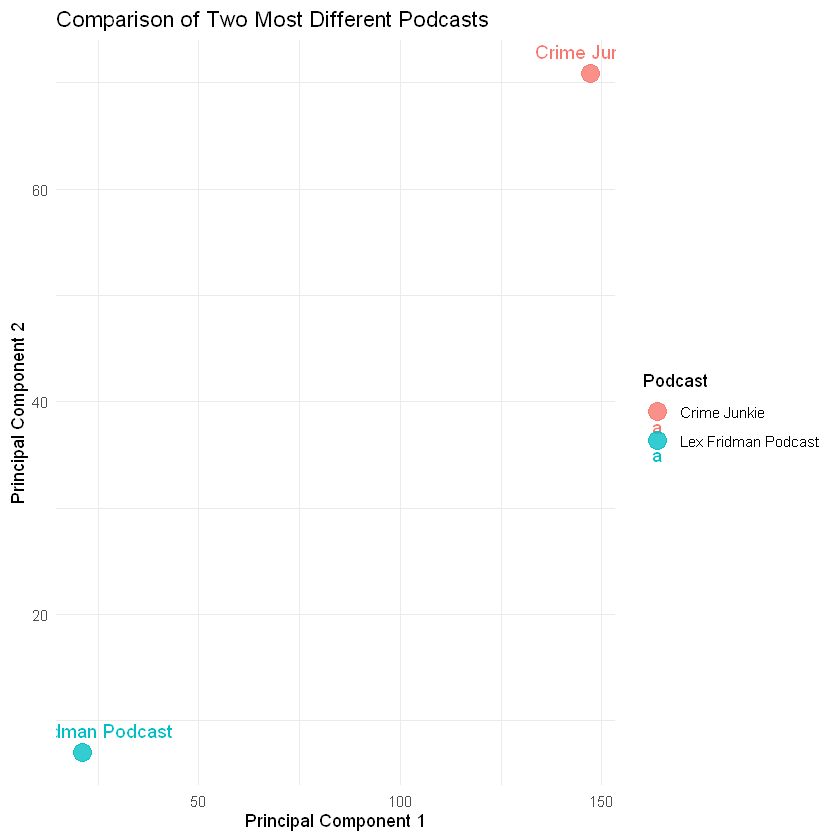

In [108]:
compare_podcasts <- pca_scores %>%
  filter(show_name %in% c("Lex Fridman Podcast", "Crime Junkie"))

# 绘制对比图
ggplot(compare_podcasts, aes(x = PC1, y = PC2, color = show_name)) +
  geom_point(size = 5, alpha = 0.8) +
  geom_text(aes(label = show_name), vjust = -1, size = 4) +
  labs(
    title = "Comparison of Two Most Different Podcasts",
    x = "Principal Component 1",
    y = "Principal Component 2",
    color = "Podcast"
  ) +
  theme_minimal() +
  theme(legend.position = "right")

In [48]:
# 假设你已经有了 PCA 结果 pca_outr 和类别信息 categories

# 1. 提取前两个主成分得分
pca_scores <- as.data.frame(pca_outr$x[, 1:2])  # 提取前两个主成分
#colnames(pca_scores) <- c("PC1", "PC2")         # 给主成分命名
pca_scores$show_name <- rownames(pca_outr$x)    # 添加节目名称

# 假设 categories 是一个数据框，包含 show_name 和 category 两列
categories_df <- token_desc %>%
  select(show_name, category) %>%
  distinct()

# 确保类别信息与 PCA 数据对齐
pca_scores <- pca_scores %>%
  left_join(categories_df, by = "show_name")  # 根据 show_name 合并类别信息

In [50]:
# 2. 基于 PCA 的数据进行 K-Means 聚类
set.seed(42)                                    # 设置随机种子保证结果可复现
kmeans_result <- kmeans(pca_scores[, c("PC1", "PC2")], centers = 20)
pca_scores$cluster <- as.factor(kmeans_result$cluster)  # 将聚类结果添加到数据

Warning message:
"did not converge in 10 iterations"


In [51]:
head(pca_scores)

,PC1,PC2,show_name,category,cluster
,<dbl>,<dbl>,<chr>,<chr>,<fct>
1,-77557.0776,5494.62601,Dr. Berg’s Healthy Keto and Intermittent Fasting Podcast,Health,8
2,-5437.6928,-71788.60793,Coach Corey Wayne,Self-Improvement,9
3,-299.2433,-30.56205,Hurrdat Sports Radio,Sports,1
4,-374.1800,-394.78126,Relaxing White Noise,Lifestyle,13
5,-642.2108,-466.64223,The Early Edge: A Daily Sports Betting Podcast,Sports,15
6,-1569.1413,-972.98385,Sports Gambling Podcast,Sports,15


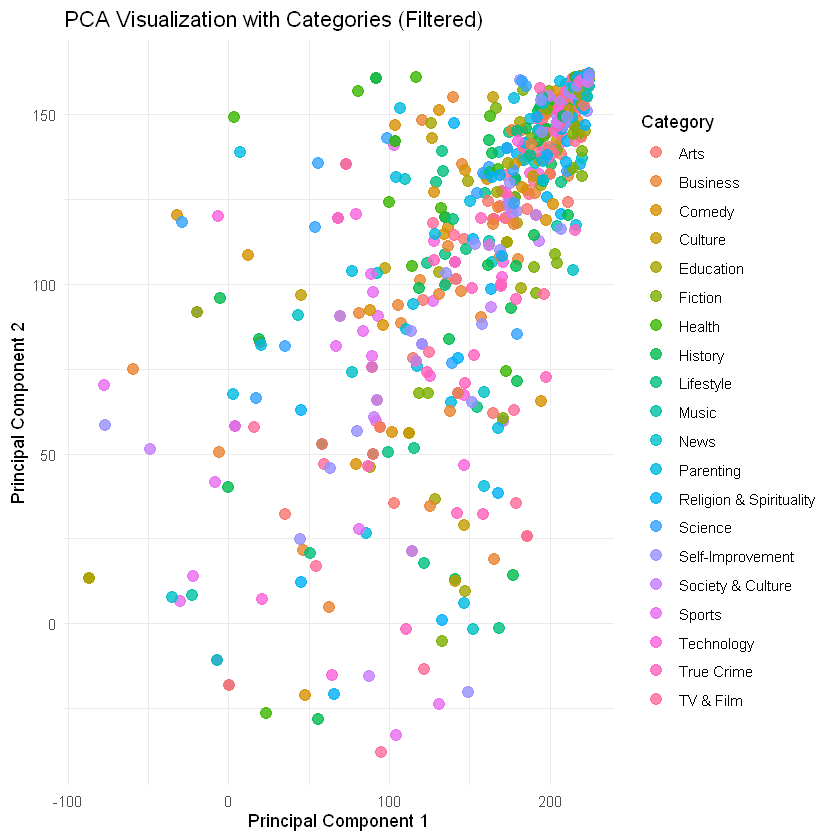

In [55]:
# 计算 PC1 和 PC2 的上下分位数范围（例如：1% 和 99%）
pc1_limits <- quantile(pca_scores$PC1, probs = c(0.1, 0.9))
pc2_limits <- quantile(pca_scores$PC2, probs = c(0.1, 0.9))

# 筛选出位于范围内的数据点
filtered_pca_scores <- pca_scores %>%
  filter(PC1 >= pc1_limits[1], PC1 <= pc1_limits[2],
         PC2 >= pc2_limits[1], PC2 <= pc2_limits[2])

# 绘制过滤后的 PCA 可视化图

ggplot(filtered_pca_scores, aes(x = PC1, y = PC2, color = as.factor(category))) +
  geom_point(size = 3, alpha = 0.8) +           # 绘制散点图
  labs(
    title = "PCA Visualization with Categories (Filtered)",
    x = "Principal Component 1",
    y = "Principal Component 2",
    color = "Category"                         # 图例标题
  ) +
  theme_minimal() +
  theme(legend.position = "right")

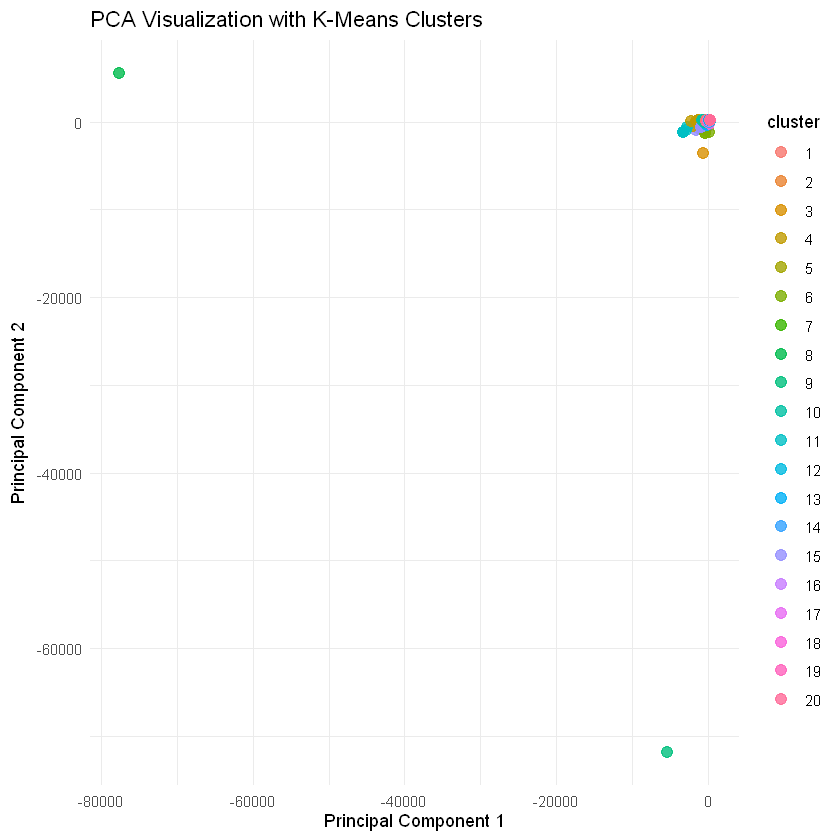

In [53]:
# 4. 绘制二维 PCA 图，颜色表示聚类结果
ggplot(pca_scores, aes(x = PC1, y = PC2, color = cluster)) +
  geom_point(size = 3, alpha = 0.8) +           # 绘制散点图
  labs(
    title = "PCA Visualization with K-Means Clusters",
    x = "Principal Component 1",
    y = "Principal Component 2"
  ) +
  theme_minimal() +
  theme(legend.position = "right")

### check

In [32]:
episode_pca_scores <- fread("episode_pca_scores.csv")

podcast_pca_scores <- fread("pca_scores2.csv")

data <- read.csv("cleaned_descriptions.csv", stringsAsFactors = FALSE)

In [33]:
colnames(episode_pca_scores) 
colnames(podcast_pca_scores)         
colnames(data)

[1] "PC1"       "PC2"       "PC3"       "PC4"       "PC5"       "PC6"      
 [7] "PC7"       "PC8"       "PC9"       "PC10"      "name"      "show_name"

[1] "PC1"       "PC2"       "PC3"       "PC4"       "PC5"       "PC6"      
 [7] "PC7"       "PC8"       "PC9"       "PC10"      "show_name"

[1] "show_id"           "name"              "description"      
 [4] "release_date"      "duration_minutes"  "id"               
 [7] "audio_preview_url" "explicit"          "language"         
[10] "category"          "show_name"

In [34]:
# Check if each show_name has a unique category
unique_category_check <- data %>%
  group_by(show_name) %>%                     # Group by show_name
  summarise(unique_categories = n_distinct(category)) %>%  # Count distinct categories for each show_name
  filter(unique_categories > 1)              # Filter show_names with more than 1 unique category

# Print the results
if (nrow(unique_category_check) == 0) {
  print("Each show_name corresponds to a unique category.")  # All show_names have unique categories
} else {
  print("The following show_names have multiple categories:")  # Some show_names have multiple categories
  print(unique_category_check)
}

[1] "The following show_names have multiple categories:"
# A tibble: 62 × 2
   show_name                                           unique_categories
   <chr>                                                           <int>
 1 " What Now? with Trevor Noah"                                       2
 2 "2 Bears, 1 Cave with Tom Segura & Bert Kreischer"                  2
 3 "48 Hours"                                                          2
 4 "8 Hour Sleep Music"                                                2
 5 "A History of Rock Music in 500 Songs"                              2
 6 "Armchair Expert with Dax Shepard"                                  2
 7 "Chuckle Sandwich"                                                  2
 8 "Culture & Christianity: The Allen Jackson Podcast"                 3
 9 "Culture Kids Podcast"                                              2
10 "Culture Matters"                                                   2
# ℹ 52 more rows


In [35]:
# 示例：选择一个有重复类别的 show_name，比如 "What Now? with Trevor Noah"
target_show <- "What Now? with Trevor Noah"

# 检查 episode_pca_scores 中是否包含该 show
filtered_episodes <- episode_pca_scores %>%
  filter(show_name == target_show)

# 查看结果
if (nrow(filtered_episodes) > 0) {
  print(paste("Found", nrow(filtered_episodes), "episodes for the show:", target_show))
} else {
  print(paste("No episodes found for the show:", target_show))
}

[1] "Found 57 episodes for the show: What Now? with Trevor Noah"


In [36]:
# 示例：选择一个有重复类别的 show_name，比如 "What Now? with Trevor Noah"
target_show <- " What Now? with Trevor Noah"

# 检查 episode_pca_scores 中是否包含该 show
filtered_episodes <- data %>%
  filter(show_name == target_show)

# 查看结果
if (nrow(filtered_episodes) > 0) {
  print(paste("Found", nrow(filtered_episodes), "episodes for the show:", target_show))
} else {
  print(paste("No episodes found for the show:", target_show))
}

[1] "Found 114 episodes for the show:  What Now? with Trevor Noah"


In [37]:
# 示例：选择一个目标 show_name，比如 "What Now? with Trevor Noah"
target_show <- "What Now? with Trevor Noah"

# 筛选出该 show 的所有 episodes
show_episodes <- episode_pca_scores %>%
  filter(show_name == target_show)

# 检查是否有重复的 episode name
duplicated_episodes <- show_episodes %>%
  filter(duplicated(name) | duplicated(name, fromLast = TRUE))

# 显示结果
if (nrow(duplicated_episodes) > 0) {
  print(paste("Found", nrow(duplicated_episodes), "duplicate episode names for the show:", target_show))
  print(duplicated_episodes)  # 显示重复的 episode
} else {
  print(paste("No duplicate episode names found for the show:", target_show))
}

[1] "No duplicate episode names found for the show: What Now? with Trevor Noah"


In [38]:
# 示例：选择一个目标 show_name，比如 "What Now? with Trevor Noah"
target_show <- " What Now? with Trevor Noah"

# 筛选出该 show 的所有 episodes
show_episodes <- data %>%
  filter(show_name == target_show)

# 检查是否有重复的 episode name
duplicated_episodes <- show_episodes %>%
  filter(duplicated(name) | duplicated(name, fromLast = TRUE))

# 显示结果
if (nrow(duplicated_episodes) > 0) {
  print(paste("Found", nrow(duplicated_episodes), "duplicate episode names for the show:", target_show))
  #print(head(duplicated_episodes))  # 显示重复的 episode
} else {
  print(paste("No duplicate episode names found for the show:", target_show))
}

[1] "Found 114 duplicate episode names for the show:  What Now? with Trevor Noah"


In [39]:
# Ensure categories are unique and aligned
categories_df <- token_desc %>%
    select(show_name, category) %>%
    distinct()

categories_df <- categories_df %>%
  group_by(show_name) %>%
  summarise(category = first(category))  # 选择第一个 category

# Merge category data
episode_pca_scores  <- episode_pca_scores %>%
    left_join(categories_df, by = "show_name")
# Merge category data
podcast_pca_scores  <- podcast_pca_scores %>%
    left_join(categories_df, by = "show_name")

In [40]:
# Check the results
head(episode_pca_scores,2)
head(podcast_pca_scores,2)

PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,name,show_name,category
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>
-0.01421346,-0.001486776,-0.039206703,0.01142298,0.001078914,0.02793339,-0.01838186,0.05512335,-0.011474859,-0.020752743,"Everything You Need to Know About AA Meetings in Scranton, PA",Technology,Technology
-0.01177125,-0.015670361,-0.007925717,0.02121250,0.019336149,0.04307559,-0.01103347,0.05561661,-0.006591615,-0.006739592,"""""The Arcade"""" - Supernatural Short Story - by A.A.Ron",TALL TALE TV - Sci-Fi and Fantasy Short Stories,Fiction


PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,show_name,category
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
-77557.078,5494.626,1705.605,-599.5691,-456.7431,-964.4781,170.1537,-1078.5725,272.9045,-36.13114,Dr. Berg’s Healthy Keto and Intermittent Fasting Podcast,Health
-5437.693,-71788.608,1370.553,-542.3193,-346.8546,-901.0877,198.5884,-637.6199,157.1333,-58.38240,Coach Corey Wayne,Self-Improvement


In [41]:
# 使用 fwrite 保存
fwrite(episode_pca_scores, "episode_pca_scores2.csv")
fwrite(podcast_pca_scores, "podcast_pca_scores2.csv")

In [61]:
# 检查 category 列中 NA 的数量
num_na <- sum(is.na(episode_pca_scores$category))

# 打印结果
cat("The number of NA values in the 'category' column:", num_na, "\n")

The number of NA values in the 'category' column: 615 


In [44]:
# 检查 category 列中 NA 的数量
num_na <- sum(is.na(podcast_pca_scores$category))

# 打印结果
cat("The number of NA values in the 'category' column:", num_na, "\n")

The number of NA values in the 'category' column: 0 


In [45]:
unmatched_show_names <- episode_pca_scores %>%
  filter(is.na(category)) %>%
  distinct(show_name)

print(unmatched_show_names)

                                                                                         show_name
                                                                                            <char>
 1:                                       Raw Talks With Vamshi Kurapati - Telugu Business Podcast
 2:                                                                        LISTEN AND SLEEP COMEDY
 3:                                                                                      Freethink
 4:                                                                     What Now? with Trevor Noah
 5:                                                                                          Quran
 6:                                                                             Therapy and Prayer
 7: Audio Porn : Sex Stories Read - BDSM stories | True sex stories | Erotic fiction | Guest audio
 8:                                                                              Lifestyle Refresh
 9:       

In [62]:
# 检查 unmatched_show_names 的 show_name 是否与 data 中一致
unmatched_show_names <- unmatched_show_names %>%
  mutate(show_name_clean = str_trim(tolower(show_name))) # 转为小写并去掉多余空格

data_clean <- data %>%
  mutate(show_name_clean = str_trim(tolower(show_name))) # 转为小写并去掉多余空格

# 匹配清理后的 show_name 列
unmatched_with_categories <- unmatched_show_names %>%
  left_join(data_clean %>% select(show_name_clean, category) %>% distinct(), 
            by = "show_name_clean")

# 查看 NA 是否减少
sum(is.na(unmatched_with_categories$category))
# 去除第二列
unmatched_with_categories <- unmatched_with_categories[, -2]

# 查看修改后的数据
head(unmatched_with_categories)

[1] 0

show_name,category
<chr>,<chr>
Raw Talks With Vamshi Kurapati - Telugu Business Podcast,Business
LISTEN AND SLEEP COMEDY,Comedy
Freethink,Technology
What Now? with Trevor Noah,Culture
What Now? with Trevor Noah,Society & Culture
Quran,Religion & Spirituality


In [64]:
# 从 episode_pca_scores 中筛选出没有 category 的行
episode_na <- episode_pca_scores %>%
  filter(is.na(category))

# 与 unmatched_with_categories 合并，添加类别信息
updated_episode_na <- episode_na %>%
  left_join(unmatched_with_categories, by = "show_name") %>%
  mutate(category = coalesce(category.x, category.y)) %>%
  select(-category.x, -category.y)  # 移除多余的列

# 将更新后的数据合并回 episode_pca_scores
episode_pca_scores_updated <- episode_pca_scores %>%
  filter(!is.na(category)) %>%  # 保留已有类别的行
  bind_rows(updated_episode_na)  # 添加更新的行

# 检查结果
cat("Number of NA categories after merge:", sum(is.na(episode_pca_scores_updated$category)), "\n")

Warning message in left_join(., unmatched_with_categories, by = "show_name"):
"Detected an unexpected many-to-many relationship between `x` and `y`.
ℹ Row 17 of `x` matches multiple rows in `y`.
ℹ Row 2 of `y` matches multiple rows in `x`.
ℹ If a many-to-many relationship is expected, set `relationship = "many-to-many"` to silence this warning."


Number of NA categories after merge: 0 


In [66]:
fwrite(episode_pca_scores_updated, "episode_pca_scores3.csv")

In [76]:
# 去除两数据集中 show_name 列中的多余空格
data <- data %>%
  mutate(show_name = str_trim(show_name))  # 去除首尾空格
n_distinct(data$show_name)

[1] 788

In [50]:
# 计算每个数据集中 show_name 的数量
num_episode_show_names <- episode_pca_scores %>%
  distinct(show_name) %>%
  nrow()

num_podcast_show_names <- podcast_pca_scores %>%
  distinct(show_name) %>%
  nrow()

num_categories_show_names <- categories_df %>%
  distinct(show_name) %>%
  nrow()

# 输出结果
cat("Number of unique show_names in episode_pca_scores:", num_episode_show_names, "\n")
cat("Number of unique show_names in podcast_pca_scores:", num_podcast_show_names, "\n")
cat("Number of unique show_names in categories_df:", num_categories_show_names, "\n")

Number of unique show_names in episode_pca_scores: 788 
Number of unique show_names in podcast_pca_scores: 800 
Number of unique show_names in categories_df: 800 


In [69]:
# 去除两数据集中 show_name 列中的多余空格
episode_pca_scores_updated <- episode_pca_scores_updated %>%
  mutate(show_name = str_trim(show_name))  # 去除首尾空格

podcast_pca_scores <- podcast_pca_scores %>%
  mutate(show_name = str_trim(show_name))  # 去除首尾空格

# 确保两者的 show_name 完全一致
common_show_names <- intersect(episode_pca_scores_updated$show_name, podcast_pca_scores$show_name)

# 筛选出共有的 show_name 的行
episode_pca_scores_filtered <- episode_pca_scores_updated %>%
  filter(show_name %in% common_show_names)

podcast_pca_scores_filtered <- podcast_pca_scores %>%
  filter(show_name %in% common_show_names)

# 检查结果
cat("Number of unique show_names in episode_pca_scores_filtered:", n_distinct(episode_pca_scores_filtered$show_name), "\n")
cat("Number of unique show_names in podcast_pca_scores_filtered:", n_distinct(podcast_pca_scores_filtered$show_name), "\n")

# 确保两者 show_name 的顺序一致
episode_pca_scores_filtered <- episode_pca_scores_filtered %>%
  arrange(show_name)

podcast_pca_scores_filtered <- podcast_pca_scores_filtered %>%
  arrange(show_name)

# 检查是否匹配
cat("Are the show_names perfectly aligned?:", 
    all(episode_pca_scores_filtered$show_name == podcast_pca_scores_filtered$show_name), "\n")

Number of unique show_names in episode_pca_scores_filtered: 788 
Number of unique show_names in podcast_pca_scores_filtered: 788 


Warning message in episode_pca_scores_filtered$show_name == podcast_pca_scores_filtered$show_name:
"longer object length is not a multiple of shorter object length"


Are the show_names perfectly aligned?: FALSE 


In [70]:
# 保存为 CSV 文件
fwrite(episode_pca_scores_filtered, "episode_pca_scores_filtered.csv")
fwrite(podcast_pca_scores_filtered, "podcast_pca_scores_filtered.csv")

In [77]:
n_distinct(podcast_pca_scores$show_name)

[1] 788